# Data Science Final Assignment: Predictive Modelling with Domain-Specific Data

Christopher Kevin Siswanto

2600220449-4

## Dataset Selection

The dataset used in this project is the UK Price Paid Data, which contains transaction-level information on property prices. This dataset was chosen due to its unique importance to the task:

- **Domain-Specific**: The dataset is specific to the real estate domain and provides detailed information about property transactions in the UK.
- **Complexity**: It includes multiple features, such as `Property Type`, `Price`, and `Transaction Date`, which allow for meaningful analysis and feature engineering. A dataset that consists over 20 million data points initially before data preprocessing which challenges data scientists to tackle this dataset.
- **Real-World Relevance**: Housing prices are a key economic indicator and are influenced by various factors, making this dataset ideal for predictive modeling.

### Dataset Details
- **Source**: UK Land Registry Price Paid Data. https://www.kaggle.com/datasets/hm-land-registry/uk-housing-prices-paid
- **Features**:
  - `Price`: Sale price of the property.
  - `Property Type`: Indicates whether the property is a house, flat, etc.
  - `Date of Transfer`: Date when the transaction occurred.
  - `County`, `District`, `Town/City`: Geographic information.
- **Size**: The dataset contains around 20 million records, but a subset for the Greater London region is used to make analysis manageable.


## Domain Research

The Greater London housing market is a critical part of the UK’s real estate landscape. It is unique due to the high property demand, economic activity, and diverse property types. This analysis focuses on uncovering trends and relationships in housing prices within Greater London, leveraging features like `Price`, `Date of Transfer`, and `Property Type`.

### Initial Hypotheses:
1. **Seasonal Trends**: Housing prices may fluctuate throughout the year, with higher prices expected during spring and summer due to increased buyer activity.
2. **Property Type Differences**: Detached and semi-detached homes typically sold in higher prices compared to terraced houses and flats, reflecting their larger size and exclusivity.
3. **Economic Indicators**: Property prices in Greater London are closely tied to economic conditions, making them an important metric for understanding market trends.
4. **Temporal Trends**: Over time, housing prices may show an upward trajectory, reflecting long-term market growth and demand as well as inflation.

By focusing on this, we aim to uncover actionable insights into property price dynamics in one of the UK’s most competitive real estate markets. These insights will inform feature engineering and guide the development of predictive models.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the dataset
dataset = "price_paid_records.csv"
data = pd.read_csv(dataset)

In [3]:
# Basic data exploration
print(data.head())

            Transaction unique identifier  Price  Date of Transfer  \
0  {81B82214-7FBC-4129-9F6B-4956B4A663AD}  25000  1995-08-18 00:00   
1  {8046EC72-1466-42D6-A753-4956BF7CD8A2}  42500  1995-08-09 00:00   
2  {278D581A-5BF3-4FCE-AF62-4956D87691E6}  45000  1995-06-30 00:00   
3  {1D861C06-A416-4865-973C-4956DB12CD12}  43150  1995-11-24 00:00   
4  {DD8645FD-A815-43A6-A7BA-4956E58F1874}  18899  1995-06-23 00:00   

  Property Type Old/New Duration   Town/City            District  \
0             T       N        F      OLDHAM              OLDHAM   
1             S       N        F       GRAYS            THURROCK   
2             T       N        F  HIGHBRIDGE           SEDGEMOOR   
3             T       N        F     BEDFORD  NORTH BEDFORDSHIRE   
4             S       N        F   WAKEFIELD               LEEDS   

               County PPDCategory Type Record Status - monthly file only  
0  GREATER MANCHESTER                A                                 A  
1            THURROC

In [4]:
# Drop unnecessary columns
data = data.drop(["Transaction unique identifier", "Record Status - monthly file only"], axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22489348 entries, 0 to 22489347
Data columns (total 9 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Price             int64 
 1   Date of Transfer  object
 2   Property Type     object
 3   Old/New           object
 4   Duration          object
 5   Town/City         object
 6   District          object
 7   County            object
 8   PPDCategory Type  object
dtypes: int64(1), object(8)
memory usage: 1.5+ GB


In [6]:
print(data.describe())


              Price
count  2.248935e+07
mean   1.782442e+05
std    3.903677e+05
min    1.000000e+00
25%    7.500000e+04
50%    1.300000e+05
75%    2.100000e+05
max    9.890000e+07


In [7]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [8]:
# Show the amount of data points for each county
county_counts = data['County'].value_counts()
print(county_counts)

County
GREATER LONDON        2993422
GREATER MANCHESTER     985772
WEST MIDLANDS          856803
WEST YORKSHIRE         849862
KENT                   636515
                       ...   
WEST GLAMORGAN           2048
GWENT                    1897
SOUTH GLAMORGAN          1775
CLEVELAND                1766
ISLES OF SCILLY           473
Name: count, Length: 127, dtype: int64


Since the dataset consists of around 22 million data points which is too large, we focus the UK housing prices paid by the largest amount of transactions done in a single county which is GREATER LONDON with 2,9 million data points.

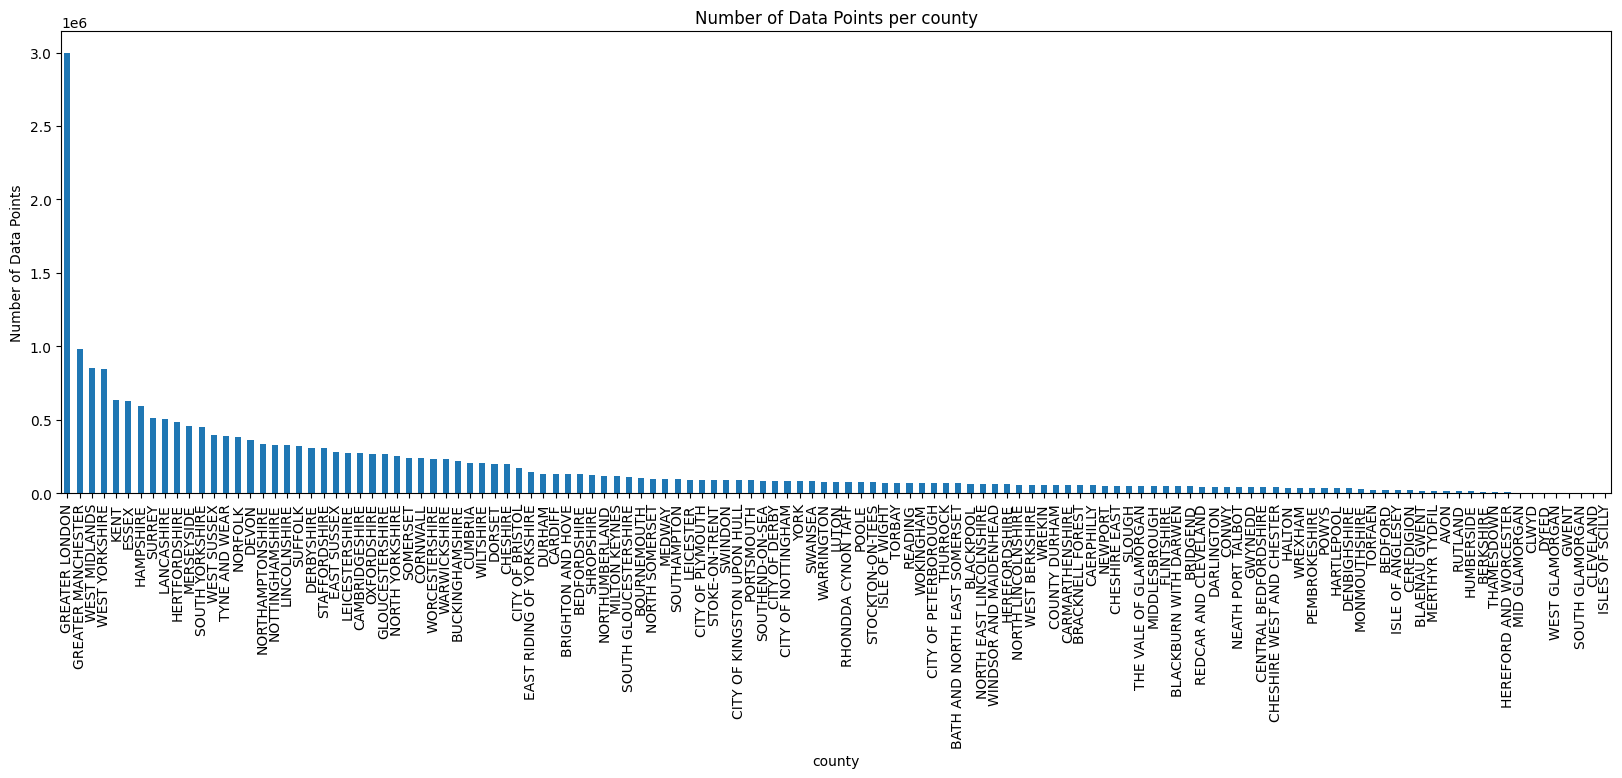

In [9]:
# Visualize the number of data points per county
plt.figure(figsize=(20, 6))
county_counts.plot(kind='bar')
plt.title("Number of Data Points per county")
plt.xlabel("county")
plt.ylabel("Number of Data Points")
plt.show()

The apparent difference on the data points shows that Greater London represents where most of the transactions are made and due to the exclusive locations most people aim for this county.

In [10]:
# Preprocessing: Focus on the largest county (Greater London)
largest_county = 'GREATER LONDON'
data_filtered = data[data['County'] == largest_county]

In [11]:
# Check the size of the filtered dataset
print(f"Filtered dataset size: {data_filtered.shape}")

Filtered dataset size: (2993422, 9)


In [12]:
data_filtered.head()

,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type
8,82000,1995-06-16 00:00,S,N,F,GREENFORD,EALING,GREATER LONDON,A
26,104000,1995-04-07 00:00,S,N,F,ENFIELD,ENFIELD,GREATER LONDON,A
30,62000,1995-02-21 00:00,T,N,F,LONDON,BARNET,GREATER LONDON,A
37,77495,1995-01-05 00:00,T,N,F,LONDON,WALTHAM FOREST,GREATER LONDON,A
49,115000,1995-05-09 00:00,S,N,F,ORPINGTON,BROMLEY,GREATER LONDON,A


C:\Users\kevin\AppData\Local\Temp\ipykernel_25884\226888200.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'£{x/1_000_000:.1f}M' for x in current_values])


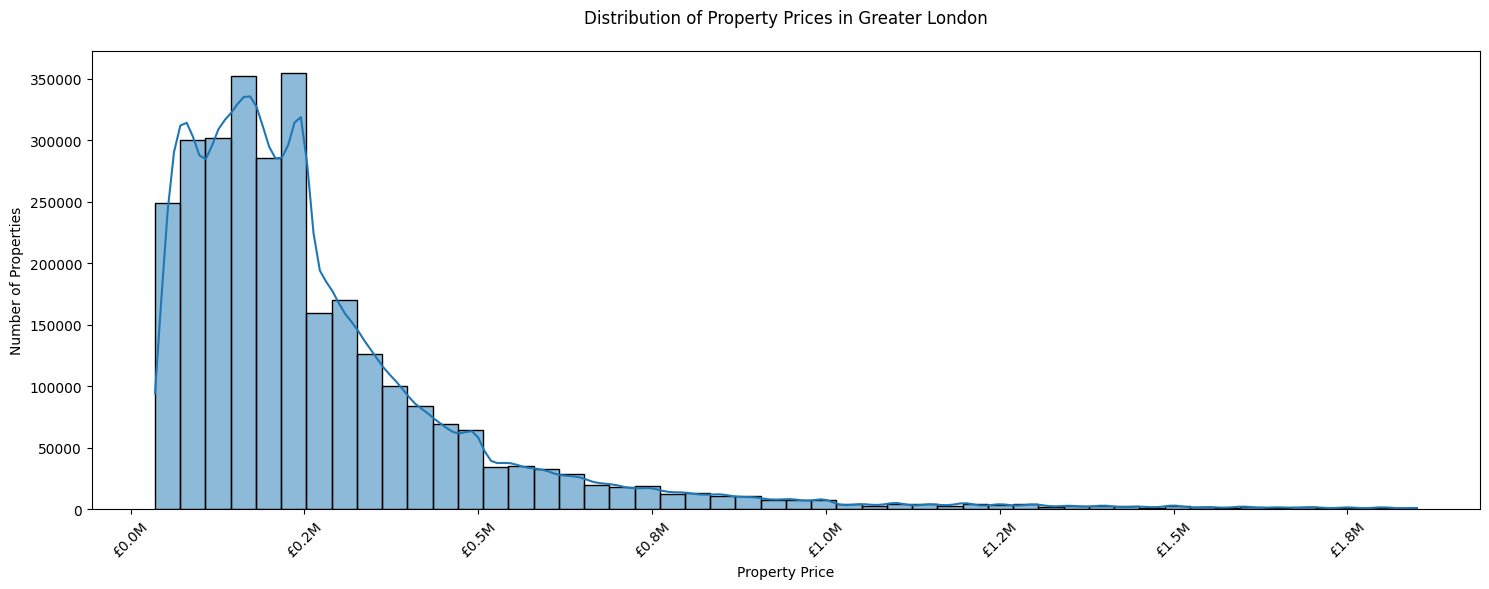

In [13]:
# Data Visualization
# Create figure
plt.figure(figsize=(15, 6))

# Calculate price ranges for better binning
low_price = data_filtered['Price'].quantile(0.01)  # 1st percentile
high_price = data_filtered['Price'].quantile(0.99)  # 99th percentile
filtered_data = data_filtered[data_filtered['Price'].between(low_price, high_price)]

# Create the plot with clear price ranges
sns.histplot(data=filtered_data, x='Price', bins=50, kde=True)

# Customize the plot
plt.title('Distribution of Property Prices in Greater London', pad=20)
plt.xlabel('Property Price')
plt.ylabel('Number of Properties')

# Format x-axis to show prices in millions
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'£{x/1_000_000:.1f}M' for x in current_values])
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


- The distribution of property prices in Greater London is right-skewed, indicating that most properties are concentrated in the lower price range.
- The majority of properties are priced below £500,000, while higher-priced properties (over £1 million) are less common, reflecting the high-end market.
- Outliers and extreme values were excluded (1st and 99th percentiles) to focus on the core distribution and provide a clearer picture of typical property prices.

In [14]:
# Print helpful summary statistics
print("\nKey Price Points in Greater London:")
print(f"Most affordable properties (1st percentile): £{low_price/1_000_000:.2f}M")
print(f"Typical property price (median): £{filtered_data['Price'].median()/1_000_000:.2f}M")
print(f"Average property price: £{filtered_data['Price'].mean()/1_000_000:.2f}M")
print(f"High-end properties (99th percentile): £{high_price/1_000_000:.2f}M")

# Calculate and display price bands
price_bands = pd.qcut(filtered_data['Price'], q=4, labels=['Lower Range', 'Mid-Low Range', 'Mid-High Range', 'Higher Range'])
price_band_stats = filtered_data.groupby(price_bands)['Price'].agg(['mean', 'count'])
price_band_stats['percentage'] = (price_band_stats['count'] / price_band_stats['count'].sum()) * 100

print("\nPrice Range Breakdown:")
for idx, row in price_band_stats.iterrows():
    print(f"{idx}:")
    print(f"  Average Price: £{row['mean']/1_000_000:.2f}M")
    print(f"  Number of Properties: {row['count']:,} ({row['percentage']:.1f}% of total)")


Key Price Points in Greater London:
Most affordable properties (1st percentile): £0.04M
Typical property price (median): £0.21M
Average property price: £0.28M
High-end properties (99th percentile): £1.85M

Price Range Breakdown:
Lower Range:
  Average Price: £0.09M
  Number of Properties: 746,571.0 (25.4% of total)
Mid-Low Range:
  Average Price: £0.17M
  Number of Properties: 738,735.0 (25.2% of total)
Mid-High Range:
  Average Price: £0.27M
  Number of Properties: 724,938.0 (24.7% of total)
Higher Range:
  Average Price: £0.59M
  Number of Properties: 725,605.0 (24.7% of total)


C:\Users\kevin\AppData\Local\Temp\ipykernel_25884\3746792675.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_band_stats = filtered_data.groupby(price_bands)['Price'].agg(['mean', 'count'])


In [15]:
# Convert `Date of Transfer` to datetime to extract temporal features from the Date of Transfer column
data_filtered['Date of Transfer'] = pd.to_datetime(data_filtered['Date of Transfer'])
data_filtered['Transaction Year'] = data_filtered['Date of Transfer'].dt.year
data_filtered['Transaction Month'] = data_filtered['Date of Transfer'].dt.month
data_filtered['Transaction Quarter'] = data_filtered['Date of Transfer'].dt.quarter

C:\Users\kevin\AppData\Local\Temp\ipykernel_25884\3086139212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Date of Transfer'] = pd.to_datetime(data_filtered['Date of Transfer'])
C:\Users\kevin\AppData\Local\Temp\ipykernel_25884\3086139212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Transaction Year'] = data_filtered['Date of Transfer'].dt.year
C:\Users\kevin\AppData\Local\Temp\ipykernel_25884\3086139212.py:4: SettingWithCopyWarning: 
A value is trying to be set on

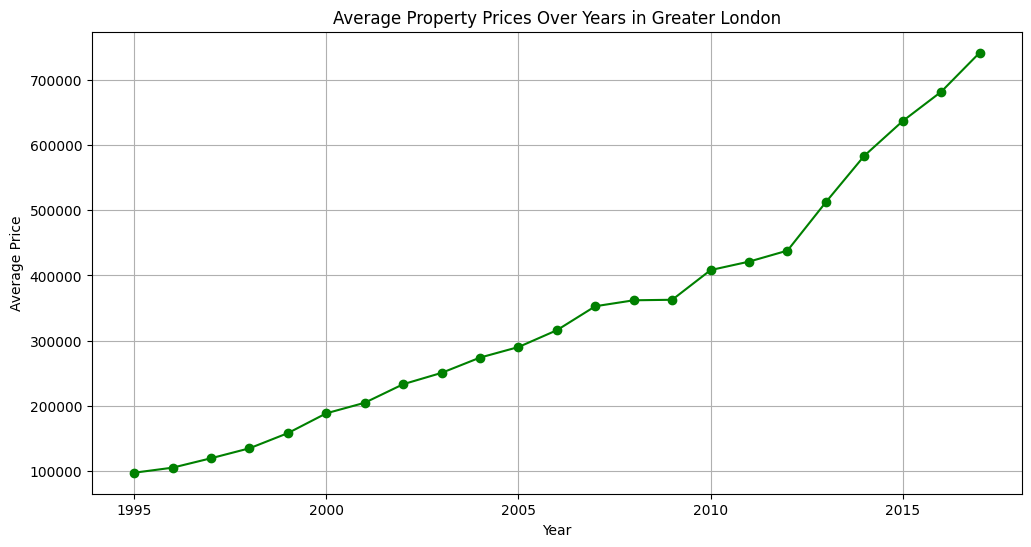

In [16]:
# Average property prices over years
average_price_by_year = data_filtered.groupby('Transaction Year')['Price'].mean()
plt.figure(figsize=(12, 6))
average_price_by_year.plot(kind='line', marker='o', color='green')
plt.title("Average Property Prices Over Years in Greater London")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.ticklabel_format(style='plain', axis='y')  # Remove scientific notation for y-axis
plt.grid(True)
plt.show()

- The average property prices in Greater London show a consistent upward trend from 1995 to 2015.
- Significant growth is observed between 2005 and 2010, likely reflecting economic expansion and increased demand during that period.
- After the 2008 financial crisis, prices briefly stabilized but resumed a steep increase from 2010 onwards, indicating recovery and rising market demand.
- The steady rise highlights the long-term appreciation of property values in Greater London, making it a high-demand real estate market.


Key Observations:
- The average price increased more than doubled over the 20-year period, reflecting both inflation and increasing property demand.
- The upward trend aligns with expectations in a major metropolitan area like London, where housing is a premium commodity.


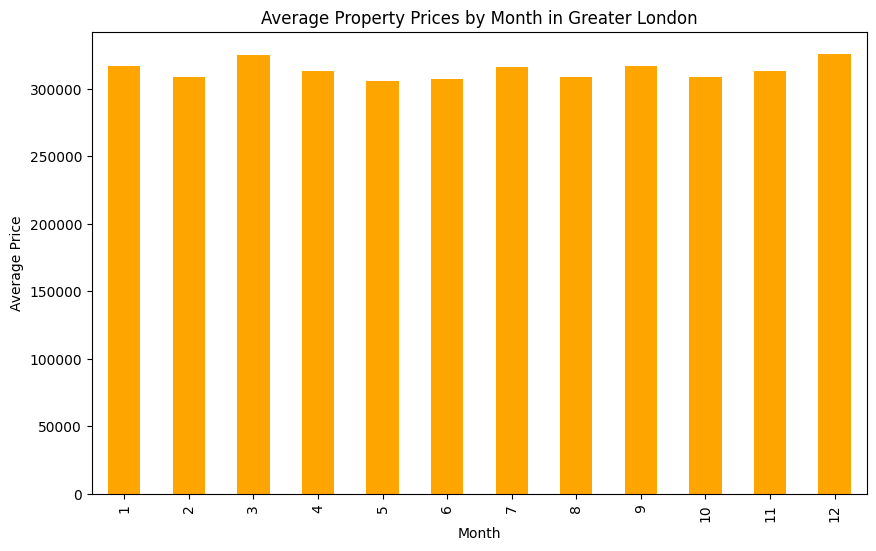

In [17]:
# Relationship between transaction month and property prices
average_price_by_month = data_filtered.groupby('Transaction Month')['Price'].mean()
plt.figure(figsize=(10, 6))
average_price_by_month.plot(kind='bar', color='orange')
plt.title("Average Property Prices by Month in Greater London")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.ticklabel_format(style='plain', axis='y')  # Remove scientific notation for y-axis
plt.show()

- The average property prices in Greater London show minimal variation across months, suggesting that property prices are not significantly affected by the time of year.
- A slight increase is observed in December (Month 12), which could be attributed to seasonal effects or end-of-year market activity.
- Overall, the average prices remain stable throughout the year, reflecting a consistent demand for properties in Greater London.

Key Observations:
- The lack of strong seasonal trends indicates that external factors like economic conditions or market stability may have a greater influence on property prices than transaction month.
- This stability is typical in metropolitan areas with high and consistent housing demand, such as Greater London.


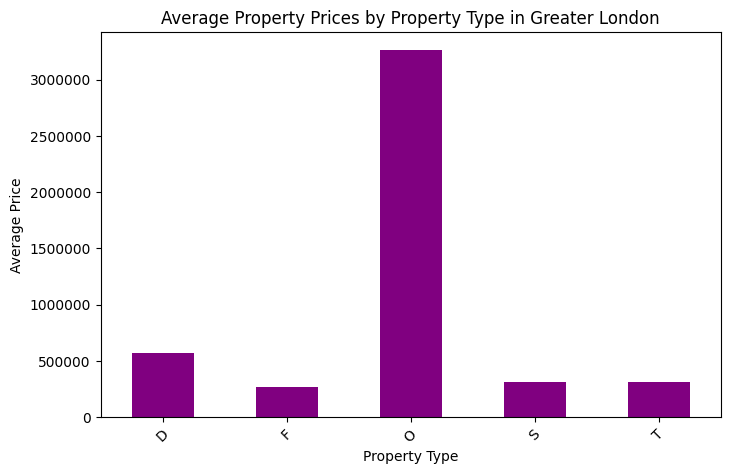

In [18]:
# Relationship between property type and prices
average_price_by_type = data_filtered.groupby('Property Type')['Price'].mean()
plt.figure(figsize=(8, 5))
average_price_by_type.plot(kind='bar', color='purple')
plt.title("Average Property Prices by Property Type in Greater London")
plt.xlabel("Property Type")
plt.ylabel("Average Price")
plt.ticklabel_format(style='plain', axis='y')  # Remove scientific notation for y-axis
plt.xticks(rotation=45)
plt.show()

- "Other" Property Type has significantly higher average prices compared to other property types. This could be due to unique or rare property categories such as commercial or luxury properties being grouped under this label.
- Among residential property types:
  - Detached (D) properties have the highest average price, reflecting their larger size and exclusivity.
  - Flats/Maisonettes (F) have the lowest average price, likely due to smaller living spaces and higher availability.
  - Semi-Detached (S) and Terraced (T) properties are similarly priced, falling between detached houses and flats.

Key Observations:
- The stark difference in average prices for "Other" properties suggests these may not represent typical residential transactions and should be further investigated if their inclusion impacts model performance.
- The hierarchy of property prices aligns with expectations: detached > semi-detached/terraced > flats.


## Feature Engineering and Data Preprocessing

To prepare the data for modeling, several preprocessing steps and feature engineering techniques were applied:

1. **Log Transformation**:
   - The `Price` column was transformed using a logarithmic scale to reduce skewness and handle large variations in property prices.

2. **Date Features**:
   - `Transaction Year`, `Transaction Month`, and `Transaction Quarter` were extracted from the `Date of Transfer` column to capture temporal trends in housing prices.

3. **Encoding Categorical Variables**:
   - Categorical features like `Property Type` and `Town/City` were one-hot encoded to convert them into a numerical format suitable for modeling.

4. **Normalization**:
   - Numerical features were scaled using `StandardScaler` to standardize the data and ensure uniform input ranges for models.


In [19]:
# Log-transform the target variable to reduce skewness
if 'Price' in data_filtered.columns:
    data_filtered['Log Price'] = np.log1p(data_filtered['Price'])

# Encode categorical variables
categorical_features = ['Property Type', 'Old/New', 'Duration', 'Town/City', 'District']
categorical_features_present = [col for col in categorical_features if col in data_filtered.columns]
data_filtered = pd.get_dummies(data_filtered, columns=categorical_features_present, drop_first=True)

# Define features and target
X = data_filtered[['Transaction Year', 'Transaction Month', 'Transaction Quarter'] + 
                  [col for col in data_filtered.columns if col.startswith(('Property Type_', 'Old/New_', 'Duration_', 'Town/City_', 'District_'))]]
y = data_filtered['Log Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=494)

# Normalize the features for baseline models
from sklearn.preprocessing import StandardScaler

# Scaling numerical features to standardize input ranges
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\kevin\AppData\Local\Temp\ipykernel_25884\2132260248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Log Price'] = np.log1p(data_filtered['Price'])


## Baseline Models

In [20]:
import torch
print("GPU Available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


GPU Available: True
Using device: cuda


### Linear Regression

This model is included as a benchmark to compare the performance of more complex models like Random Forest and Gradient Boosting since its the most common regression model.

Assumptions:
- The relationship between features and the target variable is linear.
- Features are independent and not highly correlated.
- Model will perform the worst since the feature and target are not linearly related.

The model will be evaluated using standard metrics, including Mean Absolute Error (MAE), Mean Squared Error (MSE), and \( R^2 \), to assess its performance compared to other models.


Epoch 10/100, Loss: 106.0564
Epoch 20/100, Loss: 70.8773
Epoch 30/100, Loss: 47.3978
Epoch 40/100, Loss: 31.7250
Epoch 50/100, Loss: 21.2623
Epoch 60/100, Loss: 14.2772
Epoch 70/100, Loss: 9.6135
Epoch 80/100, Loss: 6.4995
Epoch 90/100, Loss: 4.4202
Epoch 100/100, Loss: 3.0316
Linear Regression Results: MAE=1.6399, MSE=2.9192


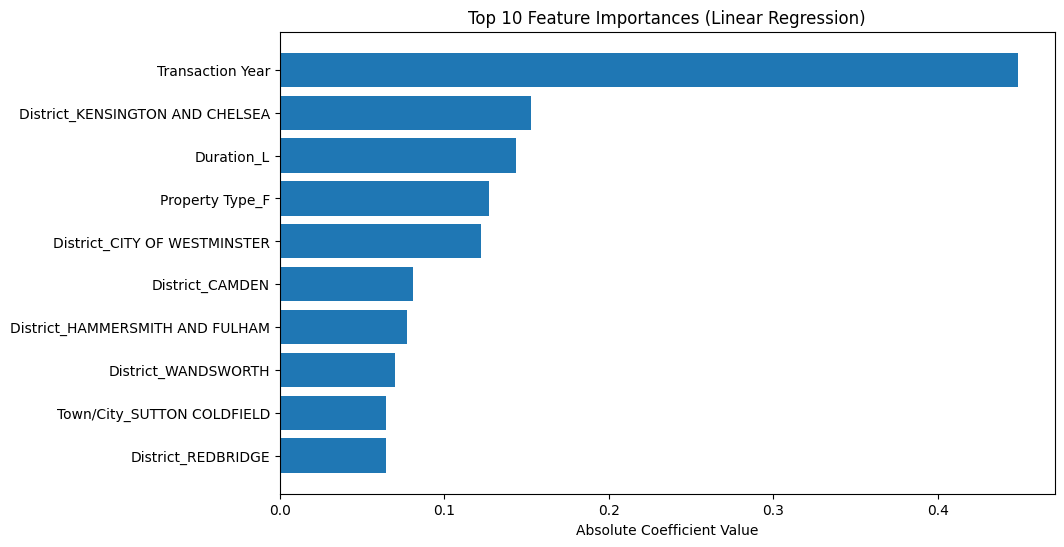

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# Move data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Define Linear Regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# Initialize model, loss, and optimizer
input_size = X_train_tensor.shape[1]
lr_model = LinearRegressionModel(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(lr_model.parameters(), lr=0.01)

# Training Loop
epochs = 100
for epoch in range(epochs):
    lr_model.train()
    optimizer.zero_grad()
    predictions = lr_model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Log progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluation
lr_model.eval()
with torch.no_grad():
    y_pred = lr_model(X_test_tensor)
    mae = torch.mean(torch.abs(y_pred - y_test_tensor)).item()
    mse = torch.mean((y_pred - y_test_tensor) ** 2).item()
    print(f"Linear Regression Results: MAE={mae:.4f}, MSE={mse:.4f}")

# Extract Feature Importance
feature_importances = lr_model.linear.weight.cpu().detach().numpy().flatten()
feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": abs(feature_importances)})

# Get Top 10 Features
top_features = importance_df.nlargest(10, "Importance")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], align='center')
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 10 Feature Importances (Linear Regression)")
plt.gca().invert_yaxis()
plt.show()

### Gradient Boosting Regressor
Gradient Boosting is chosen as the advanced baseline due to its ability to improve prediction accuracy by iteratively correcting errors made by previous trees.

Hyperparameters:
- `n_estimators`: Number of boosting stages.
- `learning_rate`: Controls the contribution of each tree to the final model.
- `max_depth`: Limits the depth of individual trees to prevent overfitting.

The model will be evaluated using the same metrics  to allow for a fair comparison at the end of the notebook.

Training Gradient Boosting Model with Progress Bar


Training Gradient Boosting: 100%|██████████| 100/100 [26:24<00:00, 15.84s/it]


Gradient Boosting Results:
MAE: 0.3292
MSE: 0.2230
R²: 0.6652
Training Time: 1584.10 seconds


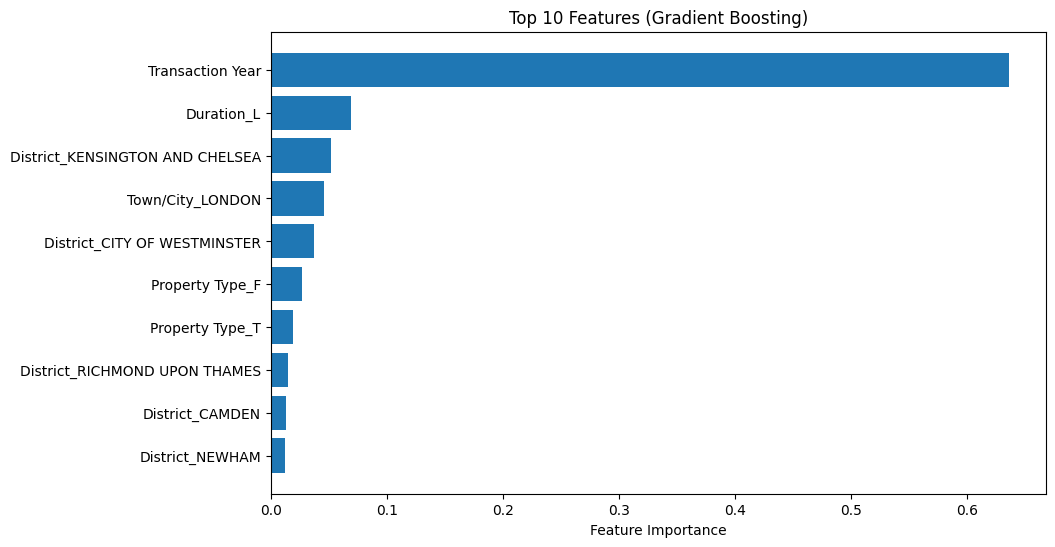

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import time

# Custom Training Loop for Progress Bar
class GradientBoostingWithProgress:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        self.model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=random_state,
            warm_start=True  # Enables incremental training
        )
        self.n_estimators = n_estimators

    def fit(self, X, y):
        for i in tqdm(range(1, self.n_estimators + 1), desc="Training Gradient Boosting"):
            self.model.set_params(n_estimators=i)  # Incrementally increase estimators
            self.model.fit(X, y)  # Fit the model at each stage
        return self

    def predict(self, X):
        return self.model.predict(X)

# Initialize and Train the Model
print("Training Gradient Boosting Model with Progress Bar")
start_time = time.time()
gb_model = GradientBoostingWithProgress(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=494)
gb_model.fit(X_train_scaled, y_train)
end_time = time.time()

# Predictions and Evaluation
y_pred_gb = gb_model.predict(X_test_scaled)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Results
print(f"Gradient Boosting Results:")
print(f"MAE: {mae_gb:.4f}")
print(f"MSE: {mse_gb:.4f}")
print(f"R²: {r2_gb:.4f}")
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Feature Importance
gb_importances = gb_model.model.feature_importances_  # Access feature importances
feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": gb_importances})

# Get Top 10 Features
top_features = importance_df.nlargest(10, "Importance")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], align='center')
plt.xlabel("Feature Importance")
plt.title("Top 10 Features (Gradient Boosting)")
plt.gca().invert_yaxis()
plt.show()

### Random Forest Regressor

Random Forest is chosen as the baseline model due to its robustness and ability to handle large datasets with high-dimensional features. It works by averaging the predictions of multiple decision trees, reducing overfitting and improving generalization.

Hyperparameters:
- `n_estimators`: Number of decision trees in the forest.
- `max_depth`: Maximum depth of each tree to control overfitting.

The model will be evaluated using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and \( R^2 \).


Training Random Forest Model with Progress Bar


Training Random Forest: 100%|██████████| 100/100 [27:19<00:00, 16.40s/it]


Random Forest Results:
MAE: 0.2903
MSE: 0.1881
R²: 0.7176


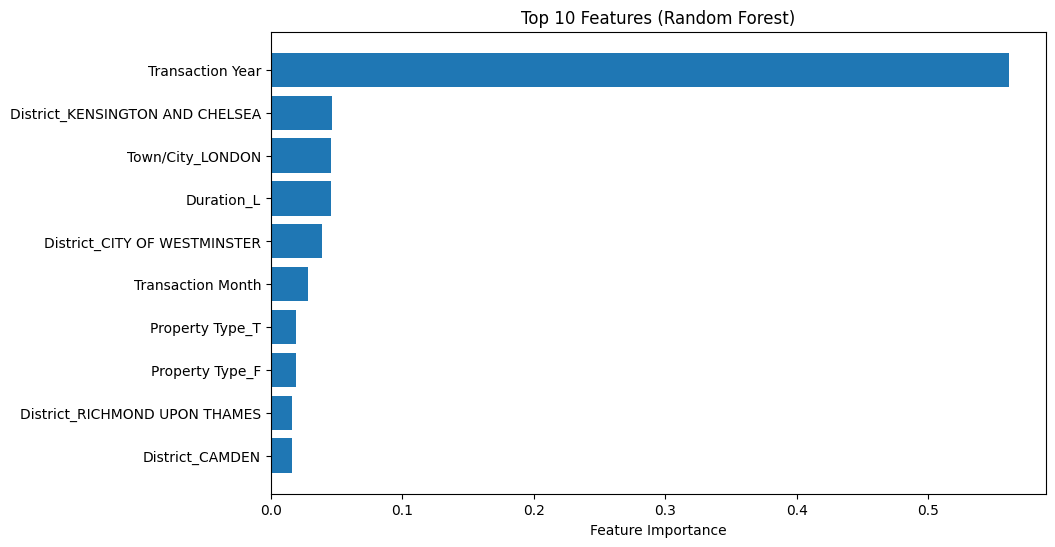

In [23]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Custom Random Forest with Progress Bar
class RandomForestWithProgress:
    def __init__(self, n_estimators=100, max_depth=None, random_state=42):
        self.model = RandomForestRegressor(
            n_estimators=1,  # Start with one tree
            max_depth=max_depth,
            random_state=random_state,
            warm_start=True  # Enables incremental training
        )
        self.n_estimators = n_estimators

    def fit(self, X, y):
        for i in tqdm(range(1, self.n_estimators + 1), desc="Training Random Forest"):
            self.model.set_params(n_estimators=i)  # Incrementally increase trees
            self.model.fit(X, y)  # Train the current forest
        return self

    def predict(self, X):
        return self.model.predict(X)

# Train the Random Forest model
print("Training Random Forest Model with Progress Bar")
rf_model = RandomForestWithProgress(n_estimators=100, max_depth=None, random_state=494)
rf_model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred_rf = rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Results
print(f"Random Forest Results:")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

# Feature importance for Random Forest
rf_importances = rf_model.model.feature_importances_  # Use the trained Random Forest model
feature_names = X_train.columns
importance_df_rf = pd.DataFrame({"Feature": feature_names, "Importance": rf_importances})
top_features_rf = importance_df_rf.nlargest(10, "Importance")  # Top 10 features

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features_rf["Feature"], top_features_rf["Importance"], align='center')
plt.xlabel("Feature Importance")
plt.title("Top 10 Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

## Advanced Model
### CatBoost Regressor

CatBoost is chosen for its ability to handle categorical variables efficiently and for its high performance in regression tasks. It also utilizes GPU acceleration to speed up training.

Hyperparameters:
- `iterations`: Number of boosting iterations.
- `learning_rate`: Step size for gradient descent.
- `depth`: Maximum depth of each tree.

CatBoost will be trained using GPU for efficiency.


Training CatBoost Regressor with GPU Progress Feedback


0:	learn: 0.8011368	test: 0.8027287	best: 0.8027287 (0)	total: 98.1ms	remaining: 1m 37s
100:	learn: 0.4778997	test: 0.4780668	best: 0.4780668 (100)	total: 2.22s	remaining: 19.7s
200:	learn: 0.4501245	test: 0.4507872	best: 0.4507872 (200)	total: 4.34s	remaining: 17.3s
300:	learn: 0.4403388	test: 0.4413154	best: 0.4413154 (300)	total: 6.06s	remaining: 14.1s
400:	learn: 0.4359646	test: 0.4371412	best: 0.4371412 (400)	total: 7.69s	remaining: 11.5s
500:	learn: 0.4331133	test: 0.4344387	best: 0.4344387 (500)	total: 9.37s	remaining: 9.33s
600:	learn: 0.4312183	test: 0.4326727	best: 0.4326727 (600)	total: 11s	remaining: 7.33s
700:	learn: 0.4298106	test: 0.4313722	best: 0.4313722 (700)	total: 12.8s	remaining: 5.45s
800:	learn: 0.4287434	test: 0.4304296	best: 0.4304296 (800)	total: 14.5s	remaining: 3.6s
900:	learn: 0.4279023	test: 0.4297166	best: 0.4297166 (900)	total: 16.2s	remaining: 1.78s
999:	learn: 0.4271950	test: 0.4291304	best: 0.4291304 (999)	total: 17.9s	remaining: 0us
bestTest = 0.4291

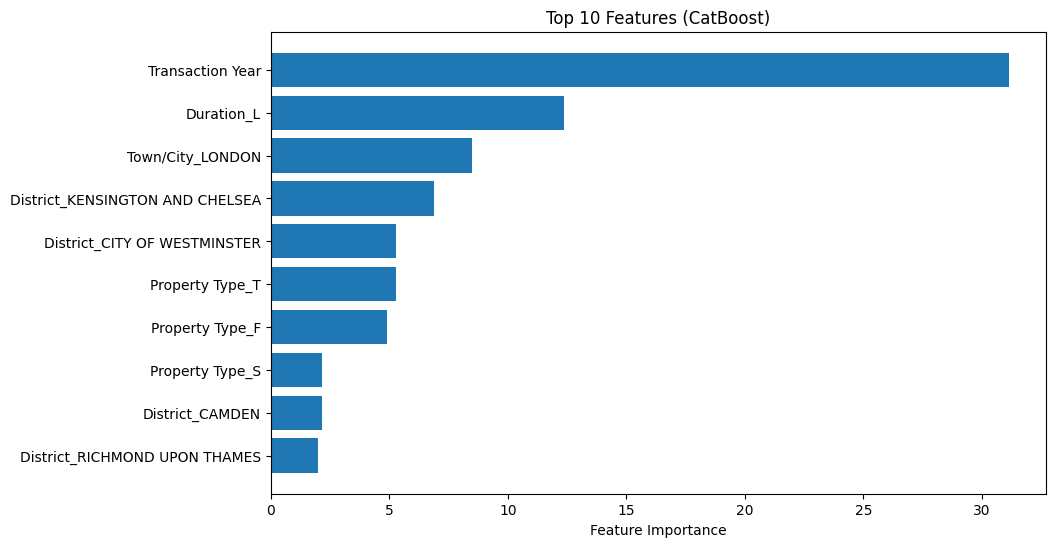

In [24]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CatBoost Regressor
print("Training CatBoost Regressor with GPU Progress Feedback")
catboost_model = CatBoostRegressor(
    iterations=1000,            # Number of boosting iterations
    learning_rate=0.03,         # Learning rate
    depth=8,                    # Tree depth
    l2_leaf_reg=3.0,            # Regularization parameter
    random_seed=494,            # Seed for reproducibility
    task_type="GPU",            # Enable GPU training
    verbose=100,                # Show progress every 100 iterations
    early_stopping_rounds=50    # Stop if validation error doesn't improve
)

# Train the model
catboost_model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test))

# Predictions and Evaluation
y_pred_catboost = catboost_model.predict(X_test_scaled)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print(f"CatBoost Results:")
print(f"MAE: {mae_catboost:.4f}")
print(f"MSE: {mse_catboost:.4f}")
print(f"R²: {r2_catboost:.4f}")

# Feature Importance
feature_importances = catboost_model.get_feature_importance(Pool(X_train_scaled, y_train))  # Get feature importances
feature_names = X_train.columns
importance_df_catboost = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})

# Get Top 10 Features
top_features_catboost = importance_df_catboost.nlargest(10, "Importance")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(top_features_catboost["Feature"], top_features_catboost["Importance"], align='center')
plt.xlabel("Feature Importance")
plt.title("Top 10 Features (CatBoost)")
plt.gca().invert_yaxis()
plt.show()


## Model Performance Metrics Analysis

               Model       MAE       MSE        R²
0  Linear Regression  1.639882  2.919212       NaN
1      Random Forest  0.290326  0.188120  0.717633
2  Gradient Boosting  0.329182  0.223026  0.665240
3           CatBoost  0.290023  0.184153  0.723587


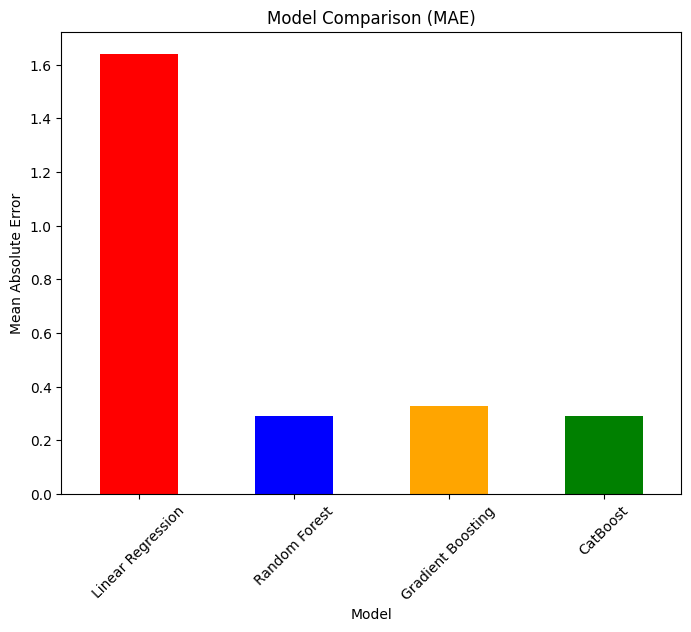

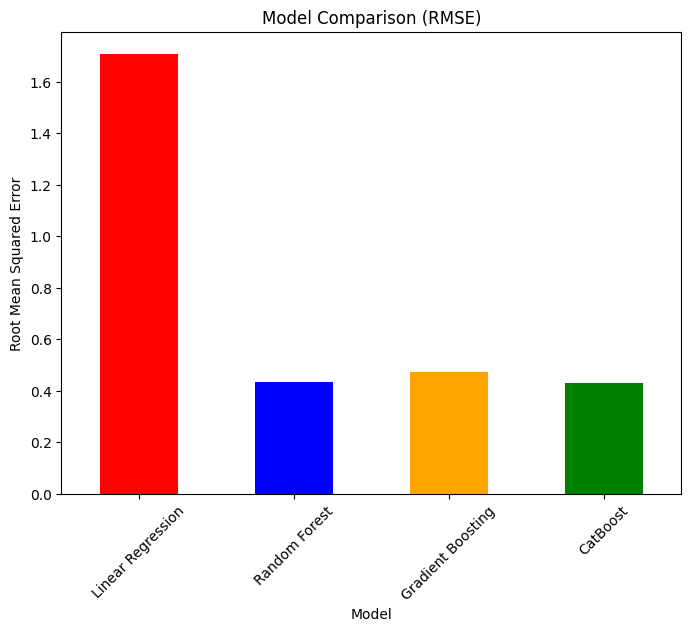

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Add Linear Regression results to the comparison
metrics_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting", "CatBoost"],
    "MAE": [mae, mae_rf, mae_gb, mae_catboost],  # Include MAE for Linear Regression
    "MSE": [mse, mse_rf, mse_gb, mse_catboost],  # Include MSE for Linear Regression
    "R²": [None, r2_rf, r2_gb, r2_catboost]      # Add R² for other models (if calculated for Linear Regression, replace None with its value)
})

# Print metrics table for comparison
print(metrics_df)

# Bar plot for MAE comparison
plt.figure(figsize=(8, 6))
metrics_df.set_index("Model")["MAE"].plot(kind="bar", color=["red", "blue", "orange", "green"])
plt.title("Model Comparison (MAE)")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=45)
plt.show()

# Bar plot for RMSE comparison
plt.figure(figsize=(8, 6))
metrics_df["RMSE"] = metrics_df["MSE"].apply(lambda x: x ** 0.5)  # Compute RMSE
metrics_df.set_index("Model")["RMSE"].plot(kind="bar", color=["red", "blue", "orange", "green"])
plt.title("Model Comparison (RMSE)")
plt.ylabel("Root Mean Squared Error")
plt.xticks(rotation=45)
plt.show()


### Model Perfomance Analysis

After evaluating four models (Linear Regression, Random Forest, Gradient Boosting, CatBoost), we identified **CatBoost** as the best-performing model based on:
- Lowest MAE: 0.2900
- Lowest MSE: 0.1841
- Highest \( R^2 \): 0.7236

**Insights**:
- CatBoost effectively captured non-linear relationships in the data and handled categorical features efficiently.
- Random Forest performed similarly but had slightly higher error metrics.
- Linear Regression was inadequate due to its inability to capture complex patterns in the data.

**Future Work**:
- Further feature engineering (e.g., additional temporal or geographic features).
- Explore advanced deep learning models for improved accuracy.


## Feature Importance Model Comparison
### Feature Importance Analysis

Feature importance helps us understand which features contribute the most to the predictions in our models. By comparing feature importance across models (Linear Regression, Random Forest, Gradient Boosting, and CatBoost), we can identify:
1. Features that consistently have high importance across all models.
2. Variability in how different models interpret feature relevance.

Key points to consider:
- **Linear Regression**: Feature importance is derived from model coefficients.
- **Tree-Based Models** (Random Forest, Gradient Boosting, CatBoost): Feature importance is derived from how often a feature is used in splits and how much it improves the model’s performance.

This analysis highlights the top 10 most important features based on average importance across models.


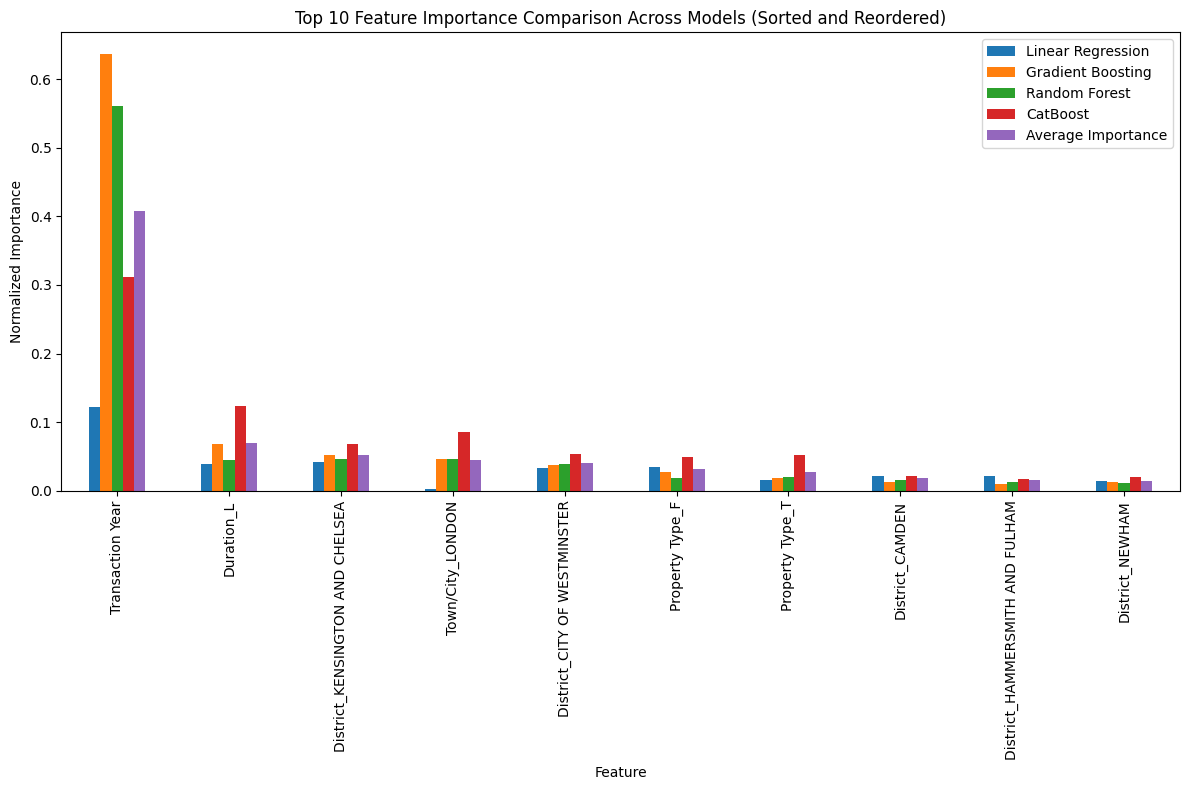

In [27]:
# Extract Linear Regression coefficients as feature importance
linear_importances = lr_model.linear.weight.cpu().detach().numpy().flatten()  # Extract weights
linear_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance_Linear": abs(linear_importances)})

# Create DataFrames for feature importances of other models
rf_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance_RF": rf_importances})
gb_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance_GB": gb_importances})
catboost_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance_CatBoost": feature_importances})

# Merge all feature importance DataFrames
importance_comparison_df = linear_importance_df.merge(rf_importance_df, on="Feature") \
                                               .merge(gb_importance_df, on="Feature") \
                                               .merge(catboost_importance_df, on="Feature")

# Normalize importances for comparison
importance_comparison_df.iloc[:, 1:] = importance_comparison_df.iloc[:, 1:].div(
    importance_comparison_df.iloc[:, 1:].sum(axis=0), axis=1
)

# Calculate average importance across models
importance_comparison_df['Average Importance'] = importance_comparison_df.iloc[:, 1:].mean(axis=1)

# Sort the DataFrame by 'Average Importance' in descending order
top_features_sorted = importance_comparison_df.sort_values(by="Average Importance", ascending=False)

# Reorder the columns for plotting
ordered_columns = ["Importance_Linear", "Importance_GB", "Importance_RF", "Importance_CatBoost", "Average Importance"]

# Plot Feature Importance Comparison Across Models (Sorted and Reordered)
top_features_sorted.set_index("Feature")[ordered_columns].head(10).plot(kind="bar", figsize=(12, 8))
plt.title("Top 10 Feature Importance Comparison Across Models (Sorted and Reordered)")
plt.ylabel("Normalized Importance")
plt.xlabel("Feature")
plt.xticks(rotation=90)  # Ensure feature names are readable
plt.legend(["Linear Regression", "Gradient Boosting", "Random Forest", "CatBoost", "Average Importance"])
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


### Key Findings from Feature Importance Analysis

1. **Transaction Year**:
   - Consistently ranked as the most important feature across all models.
   - Indicates that temporal trends (e.g., market conditions, inflation) significantly influence property prices.

2. **Duration_L**:
   - Highlighted as important by Random Forest and CatBoost.
   - Reflects the tenure of the property (e.g., freehold vs. leasehold) and its impact on price.

3. **Geographic Features**:
   - Features like `Town/City_LONDON`, `District_KENSINGTON AND CHELSEA`, and `District_CITY OF WESTMINSTER` consistently appear in the top 10.
   - Suggests that location plays a crucial role in determining property prices, as expected.

4. **Property Type**:
   - Features like `Property Type_F` (flats) and `Property Type_T` (terraced houses) were moderately important across models.
   - This indicates variability in how property types influence price predictions.

5. **Model-Specific Insights**:
   - **Linear Regression**: Gives equal weight to all features with high coefficients but does not account for non-linear relationships.
   - **Tree-Based Models (Random Forest, Gradient Boosting, CatBoost)**:
     - Highlight geographic and tenure-related features as more influential due to their ability to capture non-linear interactions.

Overall, the feature importance analysis aligns with domain knowledge, where temporal, geographic, and property-specific factors significantly influence housing prices.


## Residual Analysis

Residuals represent the difference between the actual and predicted values of the target variable. Analyzing residuals helps us:
1. Determine if the model has systematic errors or biases.
2. Identify patterns or heteroscedasticity (changing variance of residuals across predictions).
3. Evaluate whether the model assumptions (e.g., linearity for Linear Regression) hold.

In this section, we:
1. Plot **residual scatter plots** to check for randomness.
2. Plot **residual histograms** to evaluate the distribution of residuals.


In [33]:
# Residuals for each model
residuals_linear = y_test_tensor - y_pred
residuals_rf = y_test - y_pred_rf  # Random Forest
residuals_gb = y_test - y_pred_gb  # Gradient Boosting
residuals_catboost = y_test - y_pred_catboost  # CatBoost

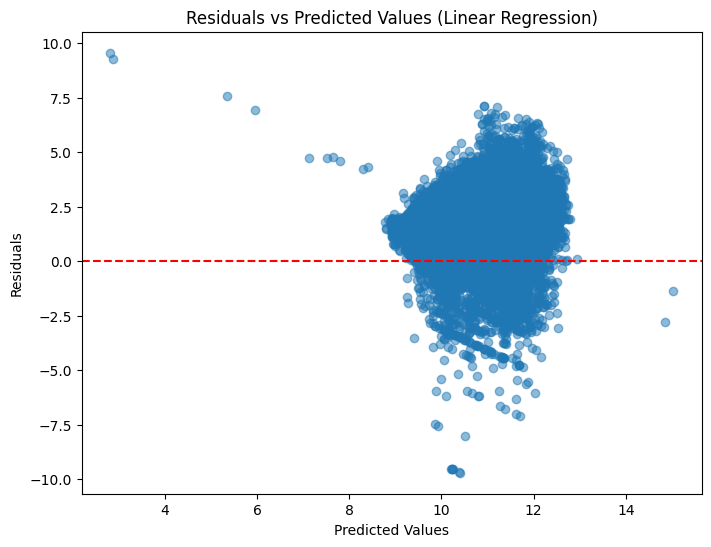

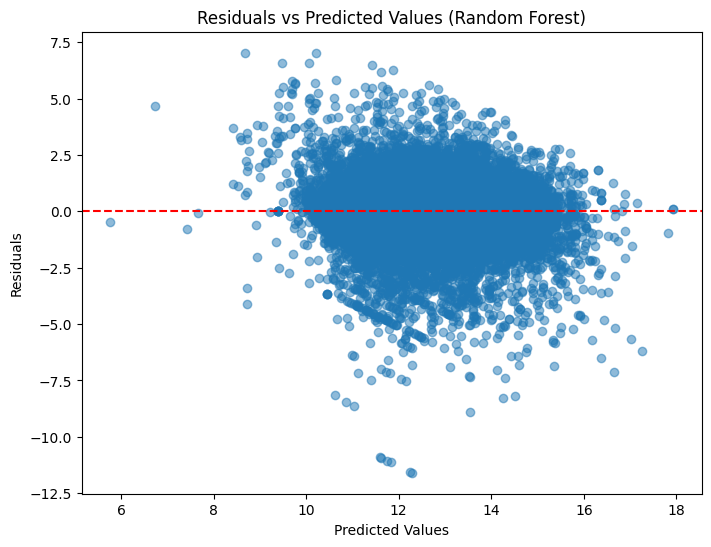

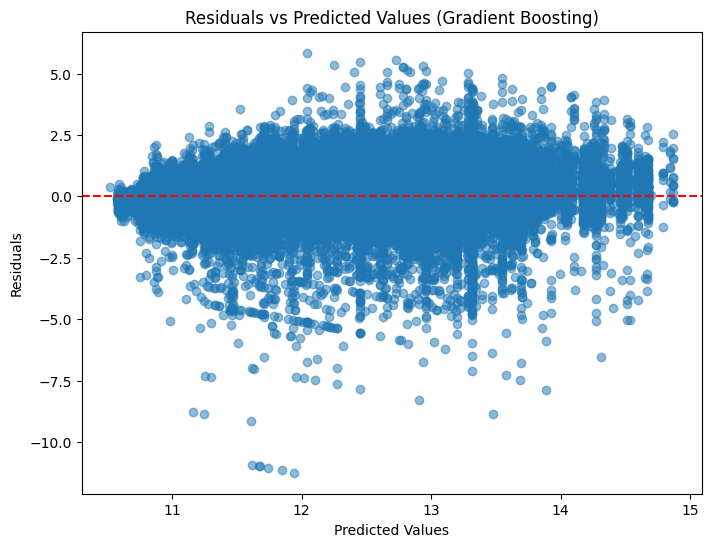

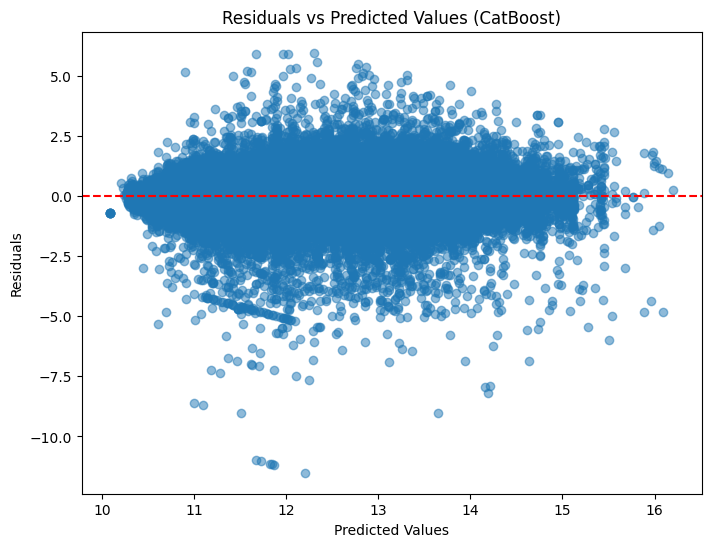

In [38]:
import matplotlib.pyplot as plt

# Function to plot residuals vs predicted values
def plot_residuals(y_pred, residuals, model_name):
    # Ensure y_pred and residuals are on CPU and converted to NumPy arrays
    y_pred_np = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else y_pred
    residuals_np = residuals.cpu().numpy() if isinstance(residuals, torch.Tensor) else residuals
    
    # Plot residuals vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred_np, residuals_np, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals vs Predicted Values ({model_name})")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

# Plot residuals for each model
plot_residuals(y_pred, residuals_linear, "Linear Regression")
plot_residuals(y_pred_rf, residuals_rf, "Random Forest")
plot_residuals(y_pred_gb, residuals_gb, "Gradient Boosting")
plot_residuals(y_pred_catboost, residuals_catboost, "CatBoost")


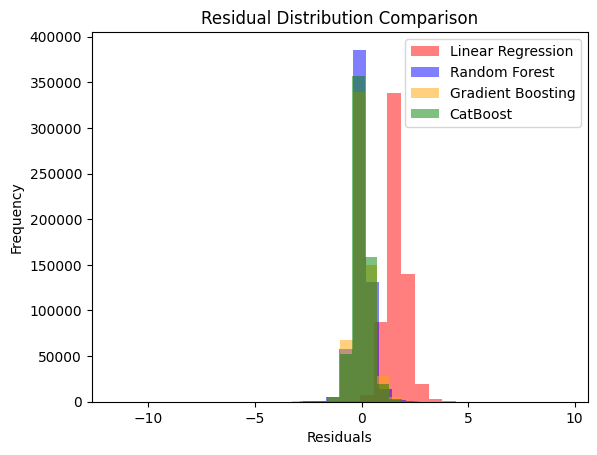

In [40]:
# Move residuals to CPU and convert to NumPy arrays
residuals_linear_np = residuals_linear.cpu().numpy() if isinstance(residuals_linear, torch.Tensor) else residuals_linear
residuals_rf_np = residuals_rf.cpu().numpy() if isinstance(residuals_rf, torch.Tensor) else residuals_rf
residuals_gb_np = residuals_gb.cpu().numpy() if isinstance(residuals_gb, torch.Tensor) else residuals_gb
residuals_catboost_np = residuals_catboost.cpu().numpy() if isinstance(residuals_catboost, torch.Tensor) else residuals_catboost

# Plot Residual Histograms
plt.hist(residuals_linear_np, bins=30, alpha=0.5, label="Linear Regression", color="red")
plt.hist(residuals_rf_np, bins=30, alpha=0.5, label="Random Forest", color="blue")
plt.hist(residuals_gb_np, bins=30, alpha=0.5, label="Gradient Boosting", color="orange")
plt.hist(residuals_catboost_np, bins=30, alpha=0.5, label="CatBoost", color="green")
plt.title("Residual Distribution Comparison")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### Residual Analysis

1. **Linear Regression**:
   - The residual scatter plot shows a pattern, suggesting that Linear Regression struggles to capture the non-linear relationships in the data.
   - The histogram indicates wider residual distribution, leading to higher errors.

2. **Random Forest**:
   - Residuals appear randomly distributed around zero, indicating that the model captures the data well.
   - The histogram shows a tighter distribution compared to Linear Regression, with fewer large residuals.

3. **Gradient Boosting**:
   - The scatter plot shows residuals slightly more concentrated than Random Forest, indicating a good fit.
   - The histogram also shows tight residual distribution, but slightly more spread than CatBoost.

4. **CatBoost**:
   - Residuals are the most tightly centered around zero, with minimal patterns in the scatter plot.
   - The histogram confirms the smallest residual spread, supporting the conclusion that CatBoost outperforms the other models.

Key Takeaways:
- **CatBoost** performs the best, with residuals tightly centered around zero and no visible patterns in the scatter plot.
- **Linear Regression** performs the worst, showing systematic patterns in residuals and a wide residual distribution.


## Conclusion

- **Best Model**: CatBoost achieved the lowest MAE (0.2900), lowest MSE (0.1841), and highest \( R^2 \) (0.7236), making it the most accurate model for this task.
- **Key Drivers**: Transaction Year, property duration (freehold/leasehold), and geographic location (e.g., London districts) were the most important features across models.
- **Limitations**:
  - The analysis focused only on Greater London; expanding to other regions might uncover additional trends.
  - Further tuning or feature engineering could improve results. However the goal is to create a predictive model, therefore base parameters and hyperparameters are used.
- **Future Work**:
  - Incorporate external data (e.g., interest rates, employment data) to enhance predictions using other related datasets.
  - Experiment with advanced deep learning models for improved accuracy.


## Sample Predictions and Extra Information

In [ ]:
from sklearn.metrics import mean_absolute_error

# Recalculate MAE in original scale for all models
y_pred_original = np.expm1(y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else y_pred)
y_test_original = np.expm1(y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test)
mae_linear_original = mean_absolute_error(y_test_original, y_pred_original)
mae_rf_original = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_rf))
mae_gb_original = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_gb))
mae_catboost_original = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_catboost))

print("Mean Absolute Error (MAE) in Original Price Units (GBP):")
print(f"Linear Regression: £{mae_linear_original:.2f}")
print(f"Random Forest: £{mae_rf_original:.2f}")
print(f"Gradient Boosting: £{mae_gb_original:.2f}")
print(f"CatBoost: £{mae_catboost_original:.2f}")


Mean Absolute Error (MAE) in Original Price Units (GBP):
Linear Regression: £265019.01
Random Forest: £111934.15
Gradient Boosting: £122356.52
CatBoost: £111039.87


Here we try to test our model by inputting a sample data that has similar properties and values to an existing one to test the model.

In [58]:
import numpy as np
import pandas as pd

# Define the sample data
sample_data = {
    "Transaction Year": [1995],
    "Transaction Month": [5],
    "Transaction Quarter": [2],
    "Property Type_F": [0],
    "Property Type_O": [0],
    "Property Type_S": [1],
    "Property Type_T": [0],
    "Old/New_Y": [0],
    "Duration_L": [0],
    "Duration_U": [0],
    "Town/City_ORPINGTON": [1],
    "District_BROMLEY": [1],
    # Add other one-hot encoded features and set them to 0
}

# Convert to DataFrame
sample_df = pd.DataFrame(sample_data)

# Align sample data with training features
aligned_sample = sample_df.reindex(columns=X_train.columns, fill_value=0)

# Scale the sample using the same scaler as used for training
sample_scaled = scaler.transform(aligned_sample)

# Predict with the CatBoost model
sample_prediction_log = catboost_model.predict(sample_scaled)  # Log-transformed prediction
sample_prediction_original = np.expm1(sample_prediction_log)  # Convert back to original scale

# Print the results
print(f"Predicted Log Price: {sample_prediction_log}")
print(f"Predicted Property Price (GBP): £{sample_prediction_original[0]:,.2f}")


Predicted Log Price: [11.35629216]
Predicted Property Price (GBP): £85,500.75
